# TO BEGIN
* Create a bunch of artificial data and explore histograms of compatibility scores

In [358]:
import pandas as pd
import numpy as np
from random import shuffle
from numpy.random import randint
import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [359]:
# Calculating the target variables
def prepDF_and_calculateEV(answers):
    # Pulling out condition info
    condition = answers['Diagnosis']
    
    # Identifying relevant medications                                                               
    ConditionFile = glob.glob('UniqueMedications/*{:s}*csv'.format(condition))[0]
    condDF = pd.read_csv(ConditionFile, sep='$', usecols=[1])
    condMeds = [med.strip() for med in list(condDF['Medication'])]

    # Reading in the massive processed dataframe                                                     
    dataframe = pd.read_csv('Final_processed_reviews/{:s}_processed.csv'.format(condition),
                            sep='$', index_col=0)

    satisfaction = dataframe['Satisfaction']

    # Identifying the feature columns and gathering that data                                        
    not_feature_columns = list(condMeds)
    DF = dataframe.drop(columns=[col for col in dataframe.columns if col not in not_feature_columns])

    # read in cluster file                                                                           
    clustering = pd.read_csv('SideEffectMatching/cluster_file.csv', sep='$', index_col=0)
    df_info = []
    for cluster in clustering.index:
        SEs = clustering.columns[clustering.loc[cluster].eq(1)]
        fSE = [dataframe[col] for col in SEs if col in dataframe.columns]
        df_info.append((np.vstack(fSE).sum(axis=0)>0))

    feature_frame = pd.DataFrame(np.array(df_info).T, columns = list(clustering.index))
                       
    # Calculating target variable                                                                    
    SEs1 = clustering.loc[answers['SE1']][clustering.loc[answers['SE1']].eq(1)].index
    fSE1 = [dataframe[col] for col in SEs1 if col in dataframe.columns]
    if fSE1:
        fSE1 = (np.vstack(fSE1).sum(axis=0)>0)
    else:
        fSE1 = np.array([0]*len(dataframe))
    
    SEs2 = clustering.loc[answers['SE2']][clustering.loc[answers['SE2']].eq(1)].index
    fSE2 = [dataframe[col] for col in SEs2 if col in dataframe.columns]
    if fSE2:
        fSE2 = (np.vstack(fSE2).sum(axis=0)>0)
    else:
        fSE2 = np.array([0]*len(dataframe))
        
    SEs3 = clustering.loc[answers['SE3']][clustering.loc[answers['SE3']].eq(1)].index
    fSE3 = [dataframe[col] for col in SEs3 if col in dataframe.columns]
    if fSE3:
        fSE3 = (np.vstack(fSE3).sum(axis=0)>0)
    else:
        fSE3 = np.array([0]*len(dataframe))
    
    w0 = answers['eff_rating']

    EffStars = (dataframe['Effectiveness']-1)/4.
    wse1 = answers['SE1_rate']
    wse2 = answers['SE2_rate']
    wse3 = answers['SE3_rate']

    # This score was designed to measure how "compatible" a drug would be with a user based on a review
    w1 = 1# - w0
    CS = w0*EffStars - w1*( wse1*fSE1  +  wse2*fSE2  +  wse3*fSE3 ) / (wse1+wse2+wse3)
    CS += 1 # Make range from 0 to 1

    feature_frame['Effectiveness'] = EffStars

    return feature_frame, DF, CS, list(clustering.index)


In [360]:
def create_random_answer(no_effectiveness=True,
                         condition='Bipolar-Disorder', 
                         cluster_file='SideEffectMatching/cluster_file.csv'):
    
    clusterDF = pd.read_csv(cluster_file, sep='$', index_col=0)
    clusters = list(clusterDF.index)
    
    response = {}
    response['Diagnosis'] = condition
    
    # Randomly draw three side effect clusters
    shuffle(clusters)
    concerns = [cluster for cluster in clusters[:3]]
    response['SE1'] = concerns[0]
    response['SE2'] = concerns[1]
    response['SE3'] = concerns[2]
    
    # Randomly set three weights for tolerance and one for effectiveness
    tolerances = (randint(1,11,size=4)-1)/10. + 0.1
    response['SE1_rate'] = tolerances[0]
    response['SE2_rate'] = tolerances[1]
    response['SE3_rate'] = tolerances[2]
    
    # Consider effectiveness
    if not no_effectiveness:
        response['eff_rating'] = tolerances[3]
    else:
        response['eff_rating'] = 0
        
    return response

# Yay clustering
* KModes?

In [361]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from kmodes import kmodes

from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

import ipyvolume
import ipyvolume as ipv
%matplotlib inline

In [362]:
def kmodes_it(x_train, 
              n_clust=4,n_init=5,
              split=0.8, seed=616):
    # Split data to do CV at some point
    
    # Fit the model
    km = kmodes.KModes(n_clusters=n_clust, init='Huang', n_init=n_init)
    clusters = km.fit_predict(x_train)
    
    # Getting ranked feature importance
    se_presence = km.cluster_centroids_
    
    return clusters, se_presence

In [363]:
def fit_model(answers, n_clust=7, nmf=False):
#     answer = create_random_answer(no_effectiveness=False, condition=condition)
    
    feature_frame, meds_frame, CS, SEclusters = prepDF_and_calculateEV(answers)
    
    if not nmf:
        clusters, se_presence = kmodes_it(feature_frame,n_clust=n_clust)
    else:
        model = NMF(n_clust,random_state=616)
        W = model.fit_transform(np.array(feature_frame).T)
        H = model.components_
        return feature_frame, W, H, CS, SEclusters
        
    medications = []
    for ind in meds_frame.index:
        for col in meds_frame:
            if meds_frame.loc[ind][col]:
                medications.append(str(col))
    
    return feature_frame, medications, clusters, se_presence, CS, SEclusters

In [309]:
def visualize_result(features, clusters, twoD=True):
    if twoD:
        pca = PCA(2)
    else:
        pca = PCA(3)
        
    vectors = pca.fit_transform(features)
    
    if twoD:
        plt.scatter(x=vectors[:,0], y=vectors[:,1], c=clusters, s=100, alpha=0.5)
    else:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
        for clust in np.unique(clusters):
            inds = np.where(clusters==clust)
            ax.scatter(vectors[:,0][inds], vectors[:,1][inds], vectors[:,2][inds], 
                       c=clusters[inds], s=100, alpha=0.5, label=clust)
            ax.legend()

In [316]:
def visualize_result2(vectors, clusters, twoD=True):
    
    colors=lambda x: cm.jet((x+0.5)/np.unique(clusters).size)
    
    if twoD:
        plt.scatter(x=vectors[:,0], y=vectors[:,1], c=clusters, s=100, alpha=0.5)
    else:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
        for clust in np.unique(clusters):
            inds = np.where(clusters==clust)
            ax.scatter(vectors[:,0][inds], vectors[:,1][inds], vectors[:,2][inds], 
                       color=colors(clust), s=100, alpha=0.5, label=clust)
            ax.legend()

In [340]:
def visualize_result3(vectors, clusters, twoD=True):
    #https://www.kaggle.com/xdsarkar/nips-papers-visualized-with-nmf-and-t-sne
    if twoD:
        n_comps = 2
    else:
        n_comps = 3
    
    tsne = TSNE(n_components=n_comps, random_state=4)
    tsne_embedding = tsne.fit_transform(vectors)
    
    colors=lambda x: cm.jet((x+0.5)/np.unique(clusters).size)
    
    if twoD:
        for clust in np.unique(clusters):
            inds = np.where(clusters==clust)
            plt.scatter(tsne_embedding[:,0][inds], 
                       tsne_embedding[:,1][inds], 
                       color=colors(clust), s=100, alpha=0.5, label=clust)
            plt.legend(loc='best')
    else:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
        for clust in np.unique(clusters):
            inds = np.where(clusters==clust)
            ax.scatter(tsne_embedding[:,0][inds], 
                       tsne_embedding[:,1][inds], 
                       tsne_embedding[:,2][inds], 
                       color=colors(clust), s=100, alpha=0.5, label=clust)
            ax.legend()

In [354]:
answer = create_random_answer(no_effectiveness=False, condition='Depression')
answer

{'Diagnosis': 'Depression',
 'SE1': 'Mood and behavioral changes',
 'SE2': 'Balance, coordination, and muscle control',
 'SE3': 'Hearing issues',
 'SE1_rate': 0.7999999999999999,
 'SE2_rate': 0.7999999999999999,
 'SE3_rate': 0.7999999999999999,
 'eff_rating': 0.30000000000000004}

In [391]:
features, meds, clusters, se_presence, CS, SEclusters  = fit_model(answer, n_clust=5)

In [364]:
features, rawW, H, CS, SEclusters = fit_model(answer, nmf=True, n_clust=5)

In [351]:
# External validation

W.shape

(30, 5)

In [269]:
clustering_SE = list(pd.read_csv('SideEffectMatching/cluster_file.csv', 


In [347]:
print(rawW.shape, H.shape)
#plt.imshow(W);plt.colorbar()
print
clustering_SE.append('Effectiveness')
#for i in range(W.shape[0]):
#    print(clustering_SE[i]+' '*(43-len(clustering_SE[i]))+ '\t'.join(['{:g}'.format(w.round(2)) for w in W[i]]))

W = (rawW-rawW.mean(axis=0))/rawW.std(axis=0)

for j in range(W.shape[1]):
    print('Topic {:g}\n'.format(j))
    keys = np.argsort(W[:,j])[::-1][:5]
    weights = W[np.argsort(W[:,j])[::-1][:5],j]
    for i in range(5):
        print(clustering_SE[keys[i]]+' '*(42-len(clustering_SE[keys[i]])) + '{}'.format(weights[i].round(2)))
    print('\n\n')

(30, 5) (5, 13247)
Topic 0

Effectiveness                             5.37
Mood and behavioral changes               0.05
Balance, coordination, and muscle control -0.02
Body aches and pain                       -0.08
Headaches and                             -0.09



Topic 1

Mood and behavioral changes               2.9
Changes in energy                         2.66
Sweating and temperature control issues   2.3
Stomach issues                            2.27
Dizziness and fainting                    -0.11



Topic 2

Sleep issues and drowsiness               5.29
Respiratory issues and coughing           0.55
Sweating and temperature control issues   0.37
Balance, coordination, and muscle control -0.04
Salivary issues                           -0.06



Topic 3

Changes in libido and sexual performance  5.2
Dry mouth and changes in taste            0.68
Vision changes                            0.66
Changes in energy                         0.27
Dental issues                           

In [344]:
clusters = np.argmax(H,axis=0)
clusters.shape

(13247,)

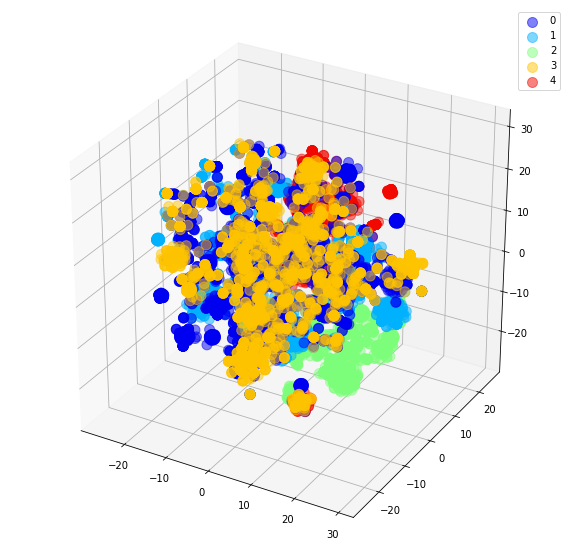

In [395]:
#visualize_result3(np.array(H).T, clusters, twoD=False)
visualize_result3(np.array(features), clusters, twoD=False)

In [167]:
np.unique(clusters)

array([0, 1, 2, 3], dtype=uint16)

In [199]:
np.unique(meds)

array(['Abilify', 'Celexa', 'Cymbalta', 'Effexor', 'Lexapro', 'Nardil',
       'Parnate', 'RemeronSoltab', 'Sarafem', 'Seroquel', 'WellbutrinXL',
       'Zoloft'], dtype='<U13')

array([0.        , 0.06666667, 0.125     , 0.19166667, 0.25      ,
       0.31666667, 0.375     , 0.44166667, 0.46666667, 0.5       ,
       0.53333333, 0.56666667, 0.59166667, 0.65833333, 0.71666667,
       0.78333333, 0.84166667, 0.90833333, 0.93333333, 0.96666667,
       1.        , 1.03333333, 1.05833333, 1.125     , 1.18333333,
       1.25      , 1.30833333, 1.375     , 1.43333333, 1.5       ])

(array([2233., 1154., 2202., 3140., 4518.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 5 Patch objects>)

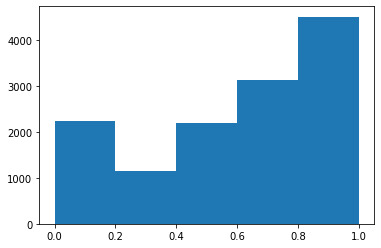

In [201]:
plt.hist(np.array(features['Effectiveness']), bins=5)

In [424]:
def CS_combo(clustarr, weights):
    scaled_clustarr = clustarr*weights
    CS = clustarr[-1]-clustarr[:-1].sum(axis=0)/sum(weights[:-1])
    return CS
    
def rank_meds(CS_cluster, meds, clusters):
    umeds = np.unique(meds)
    sorted_meds = []
    for med in umeds:
        inds = np.where(np.array(meds)==med)
        med_clust = clusters[inds]
        fracs = [(med_clust==i).sum()/len(med_clust) for i in range(len(CS_cluster))]
        sorted_meds.append(fracs)
    
    clust_ranked_inds = CS_cluster.argsort()[::-1]
    meds_best_clust = np.array(sorted_meds).T[clust_ranked_inds][0]
    ranked_meds = umeds[meds_best_clust.argsort()[::-1]]
    
    return ranked_meds

def external_validation(CS, meds, ranked_meds):
    umeds = np.unique(meds)
    median_score = []
    for med in umeds:
        inds = np.where(np.array(meds)==med)
        median_score.append(np.median(np.array(CS)[inds]))
        
    ext_ranked_meds = umeds[np.array(median_score).argsort()[::-1]]
    
    print('External'+' '*22+'Clustered')
    print('-'*8+' '*22+'-'*9)
    for i in range(len(umeds)):
        print(ext_ranked_meds[i]+' '*(30-len(ext_ranked_meds[i]))+ranked_meds[i])

features, rawW, H, CS, SEclusters = fit_model(answer, nmf=True, n_clust=5)
clusters = np.argmax(H,axis=0)        
    
inds = []
ratings = []
for key in ['SE1', 'SE2', 'SE3']:
    inds.append([i for i,val in enumerate(SEclusters) if val == answer[key]][0])
    ratings.append(answer['{:s}_rate'.format(key)])
inds.append(-1)
ratings.append(answer['eff_rating'])
    
scored_W = CS_combo(rawW[inds].T, ratings)
ranked_meds = rank_meds(scored_W, meds, clusters)
external_validation(CS, meds, ranked_meds)

External                      Clustered
--------                      ---------
Nardil                        Nardil
Parnate                       Parnate
Sarafem                       Sarafem
Effexor                       Effexor
Zoloft                        Lexapro
Lexapro                       Zoloft
Cymbalta                      Cymbalta
Celexa                        Celexa
WellbutrinXL                  Seroquel
Seroquel                      WellbutrinXL
Abilify                       Abilify
RemeronSoltab                 RemeronSoltab


In [425]:
features, meds, clusters, se_presence, CS, SEclusters  = fit_model(answer, n_clust=5)
scored_W = CS_combo(se_presence.T[inds].T, ratings)
ranked_meds = rank_meds(scored_W, meds, clusters)
external_validation(CS, meds, ranked_meds)

External                      Clustered
--------                      ---------
Nardil                        RemeronSoltab
Parnate                       Seroquel
Sarafem                       Celexa
Effexor                       Lexapro
Zoloft                        Sarafem
Lexapro                       Effexor
Cymbalta                      Zoloft
Celexa                        Abilify
WellbutrinXL                  WellbutrinXL
Seroquel                      Cymbalta
Abilify                       Nardil
RemeronSoltab                 Parnate


In [423]:
rawW[inds].sum(axis=0)

array([7.91337889, 0.        , 8.21665156, 8.44460204, 7.67650637])

In [403]:
answer['SE1'] = 'Weight changes'
answer['SE2'] = 'Sleep issues and drowsiness'
answer['SE3'] =  'Changes in libido and sexual performance'
answer['SE1_rate'] = 1
answer['SE2_rate'] = 0.4
answer['SE3_rate'] = 0.8
answer['eff_rating'] = 0.5